<a href="https://colab.research.google.com/github/suneelkumarpentela/Deep_Learning_Models/blob/master/NN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
os.getcwd()

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Mathlogic")

In [ ]:
train = pd.read_csv("./Data/train.csv")
print(train.shape)

(90000, 95)


In [ ]:
train['target_new'] = np.where(train['target']==0,0,1)
train.drop(['target'],axis=1,inplace=True)

In [ ]:
val = pd.read_csv("./Data/valid.csv")
print(val.shape)
val['target_new'] = np.where(val['target']==0,0,1)
val.drop('target',axis=1,inplace=True)

(29000, 95)


In [ ]:
test = pd.read_csv("./Data/test.csv")
print(test.shape)
test['target_new'] = np.where(test['target']==0,0,1)
test.drop('target',axis=1,inplace=True)

(29580, 95)


In [ ]:
frames = [train,test]
X = pd.concat(frames)

In [ ]:
Xtrain = X.drop('target_new',axis=1)
y_train_np = np.array([X['target_new']]).reshape(-1,1)
Xtrain.shape

(119580, 94)

In [ ]:
Xtest = val.drop('target_new',axis=1)
y_test_np = np.array([val['target_new']]).reshape(-1,1)
Xtest.shape

(29000, 94)

In [ ]:
y_test_np.shape

(29000, 1)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(Xtrain)

X_train_np = scaler.transform(Xtrain)

X_test_np = scaler.transform(Xtest)

In [ ]:
X_train = torch.FloatTensor(X_train_np)

X_test = torch.FloatTensor(X_test_np)

y_train = torch.FloatTensor(y_train_np)
y_test = torch.FloatTensor(y_test_np)

In [ ]:
print(y_train.shape)

torch.Size([119580, 1])


In [ ]:
batch_size = 256
num_train_batches = int(X_train_np.shape[0]/batch_size)+1
num_test_batches = int(X_test_np.shape[0]/batch_size)+1
train_data_size = X_train_np.shape[0]
test_data_size = X_test_np.shape[0]
print("Train :",num_train_batches,train_data_size)
print("Test :",num_test_batches,test_data_size)

Train : 468 119580
Test : 114 29000


In [ ]:
train_dataset = TensorDataset(X_train,y_train)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
test_dataset = TensorDataset(X_test,y_test)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)

In [ ]:
class ANN(nn.Module):
  def __init__(self):
     super().__init__()
     self.fc1 = nn.Linear(in_features=94, out_features=64)
     self.fc2 = nn.Linear(in_features=64, out_features=64)
     self.fc3 = nn.Linear(in_features=64, out_features=1)
     self.relu1 = nn.ReLU()
     self.relu2 = nn.ReLU()
     self.sigmoid = nn.Sigmoid()


  def forward(self, x):
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.fc3(x)
    x = self.sigmoid(x)
    return x

In [ ]:
model = ANN()

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
total_params

10305

In [ ]:
print(model.forward)

<bound method ANN.forward of ANN(
  (fc1): Linear(in_features=94, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (sigmoid): Sigmoid()
)>


In [ ]:
# loss_func = nn.BCELoss(reduction="sum")
loss_func = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)

In [ ]:
epochs = 100

In [ ]:
losses = []
accuracy = []
val_losses = []
val_accuracy = []

for epoch in range(epochs):

  model.train()
  running_loss = 0
  running_val_loss = 0
  running_acc = 0
  running_val_acc = 0

  for i,data in enumerate(train_dataloader):
    train_x,train_y = data
    y_pred = model(train_x)
    loss = loss_func(y_pred,train_y)
    # predicted = model(torch.tensor(X_train_np,dtype=torch.float32))
    acc = (y_pred.reshape(-1).detach().numpy().round() == 
           train_y.reshape(-1).detach().numpy().round()).mean()
    running_loss += loss.item()/(num_train_batches)
    running_acc += acc/(num_train_batches)
    
    #reset grads
    optimizer.zero_grad()
    
    #backward
    loss.backward()

    #weight updates
    optimizer.step()

  print(f'Epoch: {epoch+1} Loss: {running_loss} Accuracy: {running_acc}',end = " ")

  model.eval()  
  for i,data in enumerate(test_dataloader):
    X_val,y_val = data
    y_pred_val = model(X_val)
    val_loss = loss_func(y_pred_val,y_val)
    val_acc = (y_pred_val.reshape(-1).detach().numpy().round() == 
           y_val.reshape(-1).detach().numpy().round()).mean()

    running_val_loss += val_loss.item()/(num_test_batches)
    running_val_acc += val_acc/(num_test_batches)
    
  print(f'Val Loss: {running_val_loss} Val Accuracy: {running_val_acc}')


  losses.append(running_loss)
  accuracy.append(running_acc)
  val_losses.append(running_val_loss)
  val_accuracy.append(running_val_acc)  

Epoch: 1 Loss: 0.6162483895945747 Accuracy: 0.8365706559065933 Val Loss: 0.5278491524227877 Val Accuracy: 0.9477529544346979
Epoch: 2 Loss: 0.4601297923642349 Accuracy: 0.9475827991453005 Val Loss: 0.399258917099551 Val Accuracy: 0.9479280884502924
Epoch: 3 Loss: 0.3559084130275962 Accuracy: 0.9475148332570205 Val Loss: 0.3171864222539098 Val Accuracy: 0.9481032224658867
Epoch: 4 Loss: 0.29278548485320893 Accuracy: 0.9473109355921866 Val Loss: 0.2695847554949291 Val Accuracy: 0.948190789473684
Epoch: 5 Loss: 0.2563204622357829 Accuracy: 0.9475827991453003 Val Loss: 0.243376963232693 Val Accuracy: 0.9479280884502919
Epoch: 6 Loss: 0.23611594739760103 Accuracy: 0.9475148332570219 Val Loss: 0.22813341792738231 Val Accuracy: 0.9479280884502924
Epoch: 7 Loss: 0.22484482840722442 Accuracy: 0.9473109355921859 Val Loss: 0.21927842576252787 Val Accuracy: 0.9479280884502919
Epoch: 8 Loss: 0.21725845804963348 Accuracy: 0.947514833257021 Val Loss: 0.21401948207303104 Val Accuracy: 0.94775295443469

Text(0, 0.5, 'loss')

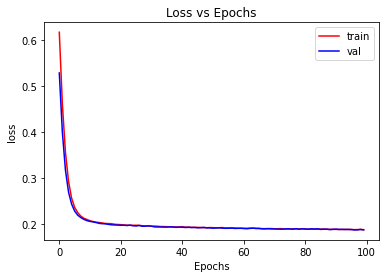

In [ ]:
plt.plot(losses,'r',label='train')
plt.plot(val_losses,'b',label='val')
plt.legend()
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

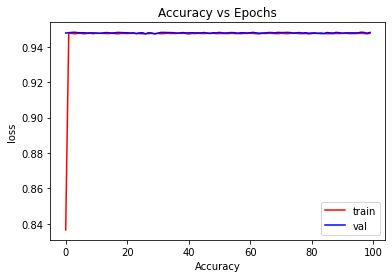

In [ ]:
plt.plot(accuracy,'r',label='train')
plt.plot(val_accuracy,'b',label='val')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.xlabel('Accuracy')
plt.ylabel('loss')

In [ ]:
model.eval()
preds_train = []
with torch.no_grad():
   for i,data in enumerate(train_loader):
     trainx,trainy = data
     y_hat = model.forward(trainx)
     preds_train.append(y_hat)

In [ ]:
preds_train = np.array(preds_train)
preds_train

array([0.08118213, 0.00289961, 0.045263  , ..., 0.03070581, 0.02625144,
       0.04998134], dtype=float32)

In [ ]:
def best_f1(preds,y_test_np):
  f1_max = 0
  cutoff = -1
  for i in np.arange(0.01,1,0.01):
    preds1 = (preds>=i)*1 
    #print(sum(preds1))
    f1_score = sklearn.metrics.precision_recall_fscore_support(preds1,y_test_np)[2][1]
    print(f1_score)
    if (not f1_score):
      break
    if (f1_score > f1_max):
      f1_max = f1_score
      cutoff = i
  return cutoff,f1_max

In [ ]:
train_cutoff,train_f1 = best_f1(preds_train,y_train_np)

0.11220965728396862
0.12648196150087113
0.14021190216853152
0.1526209301324456
0.16295832027577564
0.17145438801249954
0.17937993187012202
0.18964308890330953
0.1988232074438971
0.20631067961165048
0.20256776034236804
0.18726708074534162
0.16665109761793553
0.13600352112676056
0.10759651307596513
0.07555982964692952
0.046918257321870896
0.027322404371584702
0.0155448468832582
0.010367577756833175
0.004748338081671414
0.0022246941045606233
0.001591089896579157
0.00031842063365706094
0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
train_cutoff,train_f1

(0.09999999999999999, 0.20631067961165048)

In [ ]:
preds_train_ideal = (preds_train>=train_cutoff)*1

In [ ]:
print(classification_report(preds_train_ideal,y_train_np))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92    104436
           1       0.35      0.15      0.21     15144

    accuracy                           0.86    119580
   macro avg       0.62      0.55      0.56    119580
weighted avg       0.82      0.86      0.83    119580



In [ ]:
model.eval()
preds = []
with torch.no_grad():
   for i,data in enumerate(test_loader):
     test_x,test_y = data
     y_hat = model.forward(test_x)
     preds.append(y_hat)

In [ ]:
cutoff,f1_max = best_f1(preds,y_test_np)

0.11122399066862326
0.12516492215674202
0.1390616167326173
0.1494704272283708
0.16022439625094068
0.1687947679850514
0.17669971671388102
0.18668379362020981
0.1984924623115578
0.20214395099540583
0.2002007024586051
0.17542748575047498
0.15752895752895751
0.1395139513951395
0.10493827160493827
0.07687959299039004
0.05075528700906344
0.031367628607277286
0.015473887814313346
0.010450685826257348
0.005263157894736841
0.005277044854881266
0.0013218770654329147
0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cutoff,f1_max

(0.09999999999999999, 0.20214395099540583)

In [ ]:
preds_ideal = (preds>=cutoff)*1

In [ ]:
print(classification_report(preds_ideal,y_test_np))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     25288
           1       0.35      0.14      0.20      3712

    accuracy                           0.86     29000
   macro avg       0.62      0.55      0.56     29000
weighted avg       0.82      0.86      0.83     29000

